In [9]:
import pandas as pd

file = r"H:\Downloads\NYpollutants.csv"
df = pd.read_csv(file)
print(df.columns.tolist())


['date', ' pm25', ' o3', ' no2', ' co']


In [10]:


import matplotlib.pyplot as plt
import seaborn as sns



C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_17412\2552404033.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M').mean()


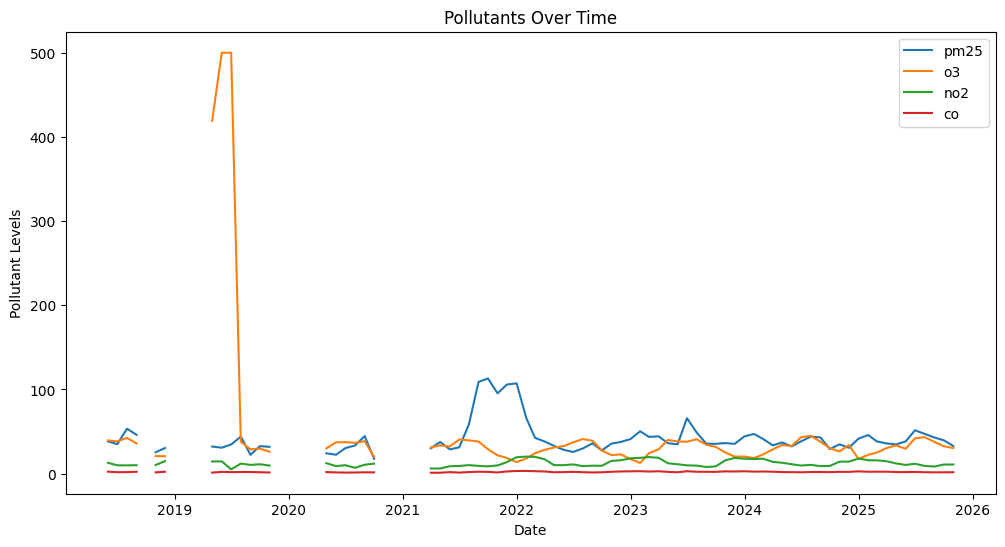

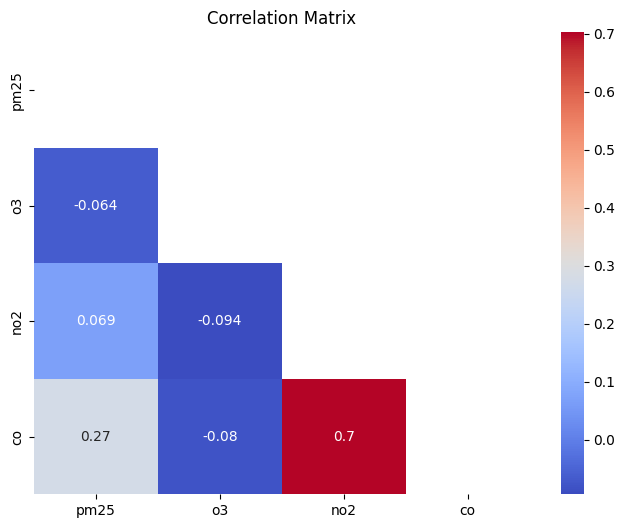

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file = r"H:\Downloads\NYpollutants.csv"

df = pd.read_csv(file)
df.columns = [col.strip() for col in df.columns]

df.dropna(inplace=True)

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Convert all pollutant columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(inplace=True)  # drop again in case conversion produced NaNs

monthly = df.resample('M').mean()

plt.figure(figsize=(12,6))
for col in monthly.columns:
    plt.plot(monthly.index, monthly[col], label=col)
plt.xlabel('Date')
plt.ylabel('Pollutant Levels')
plt.title('Pollutants Over Time')
plt.legend()
plt.show()

corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title('Correlation Matrix')
plt.show()


In [12]:
df.head()

,pm25,o3,no2,co
date,,,,
2025-10-01,21.0,26.0,7.0,1.0
2025-10-02,23.0,30.0,15.0,1.0
2025-10-03,35.0,44.0,16.0,3.0
2025-10-04,54.0,50.0,23.0,4.0
2025-10-05,71.0,36.0,17.0,2.0


AQI Formula:

### AQI / Sub-Index Formula

For a given pollutant:

I_p = ((I_Hi - I_Lo) / (BP_Hi - BP_Lo)) * (C_p - BP_Lo) + I_Lo

Where:

- I_p = AQI (or sub-index) for the pollutant
- C_p = Measured concentration of the pollutant
- BP_Lo = Breakpoint concentration corresponding to the lower AQI value
- BP_Hi = Breakpoint concentration corresponding to the higher AQI value
- I_Lo = Lower AQI value corresponding to BP_Lo
- I_Hi = Higher AQI value corresponding to BP_Hi

### Overall AQI

The overall AQI for a location is the maximum value among all pollutant sub-indices:

AQI = max(I_PM2.5, I_PM10, I_NO2, I_O3, I_CO, I_SO2)


In [13]:
#Since we are lacking some variables, but that are highly correlated we can still manage to compute AQI.

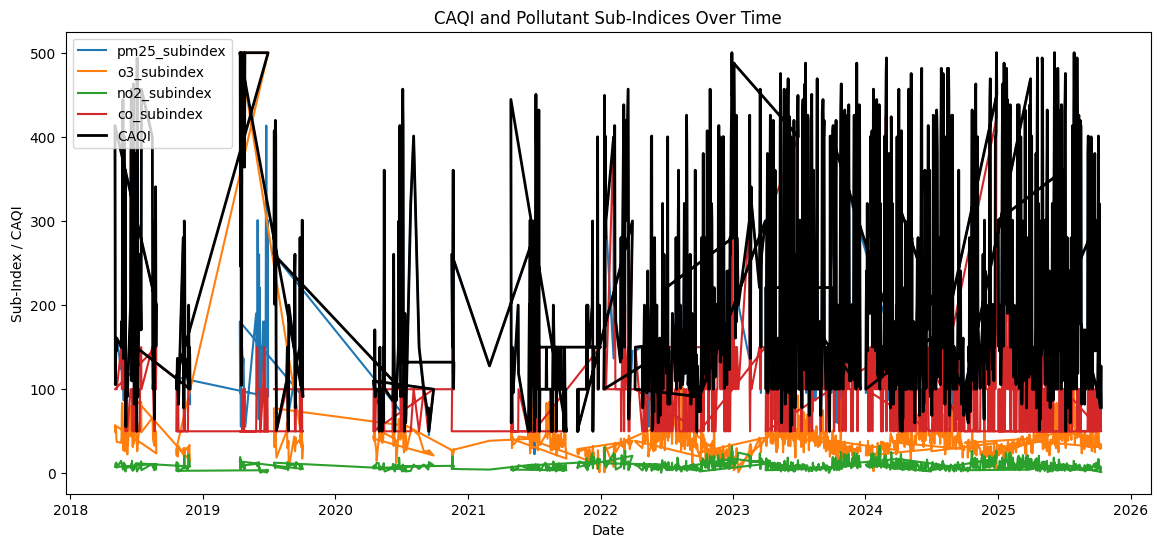

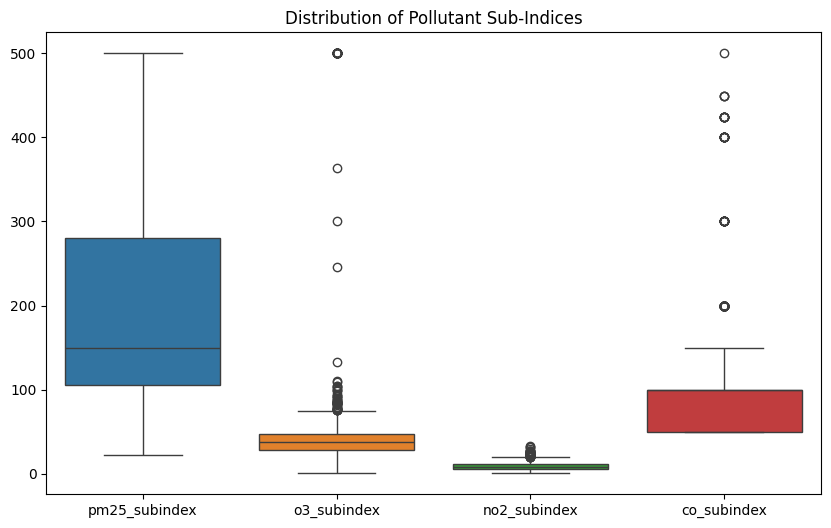

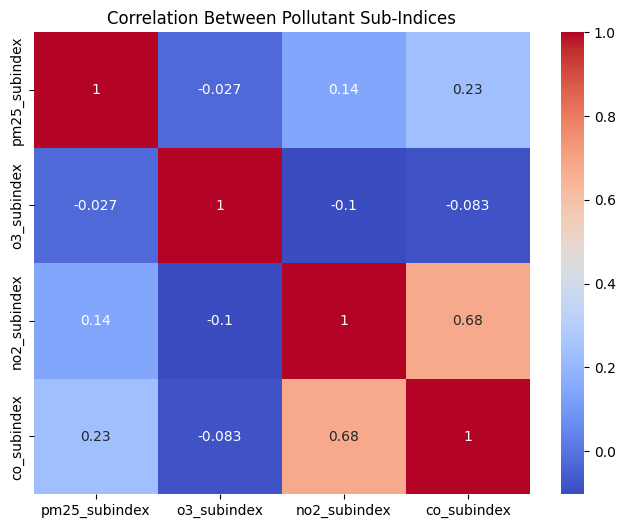

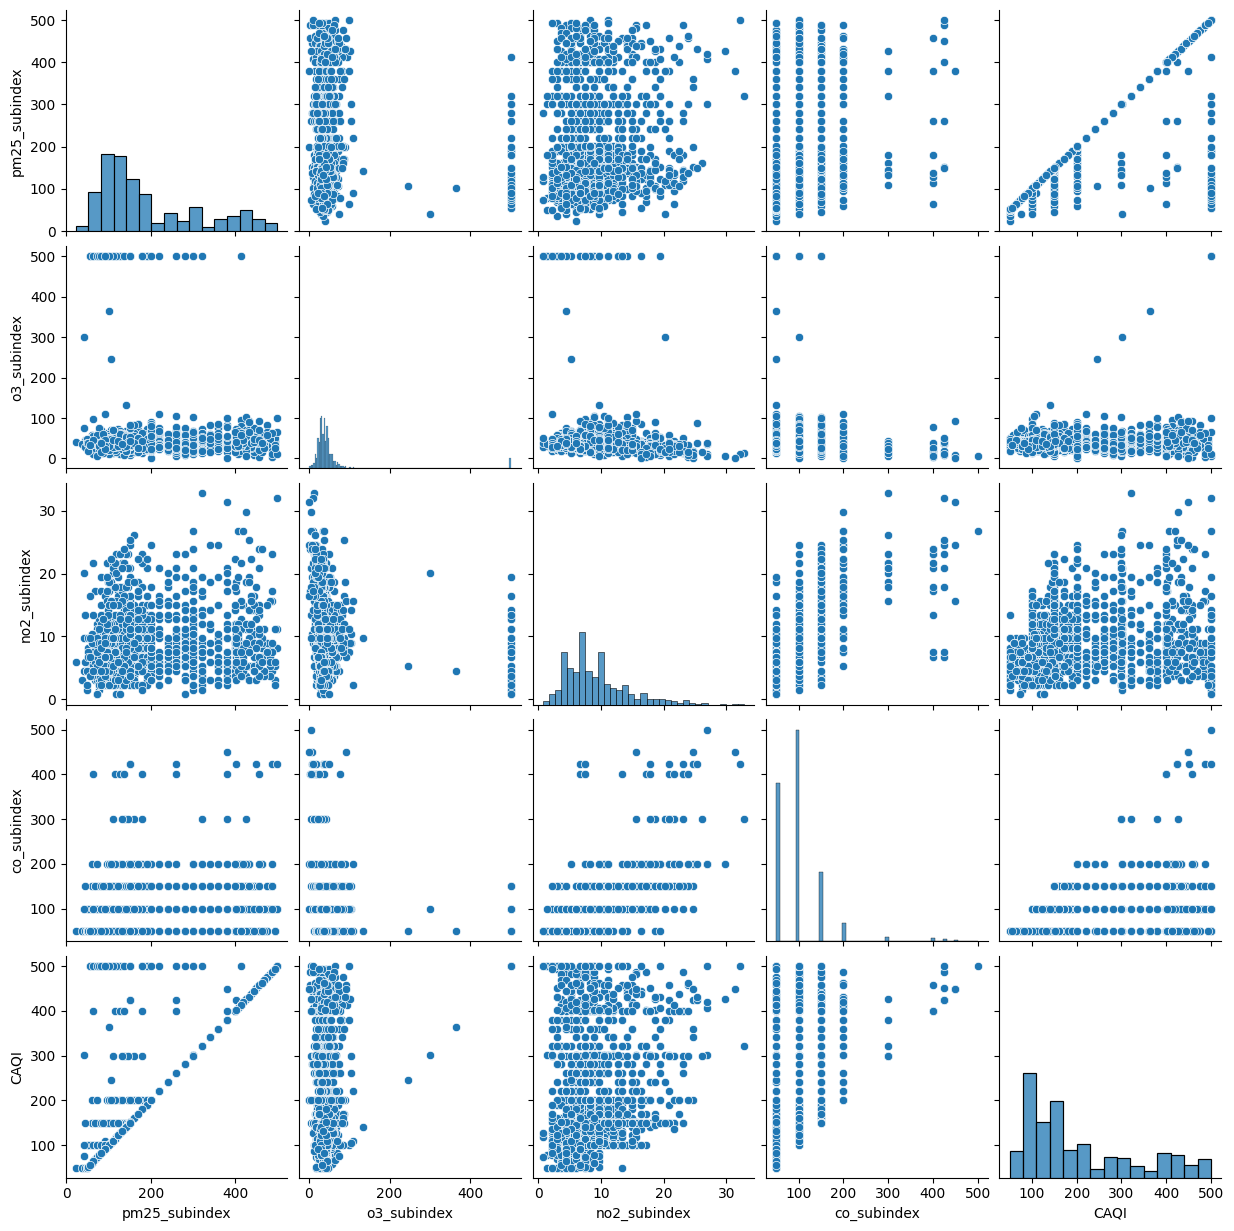

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file = r"H:\Downloads\NYpollutants.csv"
df = pd.read_csv(file)
df.columns = [col.strip() for col in df.columns]

# Keep only numeric columns
for col in df.columns:
    if col != 'date':
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# EU CAQI breakpoints
breakpoints = {
    'pm25': [(0, 11, 0, 50), (12, 23, 51, 100), (24, 35, 101, 150), (36, 41, 151, 200), (42, 47, 201, 300), (48, 53, 301, 400), (54, 70, 401, 500)],
    'o3': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 150), (181, 240, 151, 200), (241, 300, 201, 300), (301, 400, 301, 400), (401, 500, 401, 500)],
    'no2': [(0, 67, 0, 50), (68, 134, 51, 100), (135, 200, 101, 150), (201, 267, 151, 200), (268, 334, 201, 300), (335, 400, 301, 400), (401, 500, 401, 500)],
    'co': [(0, 1.0, 0, 50), (1.1, 2.0, 51, 100), (2.1, 3.0, 101, 150), (3.1, 4.0, 151, 200), (4.1, 5.0, 201, 300), (5.1, 6.0, 301, 400), (6.1, 10.0, 401, 500)],
}

def calculate_sub_index(concentration, pollutant):
    for bp in breakpoints[pollutant]:
        if bp[0] <= concentration <= bp[1]:
            return ((bp[3]-bp[2])/(bp[1]-bp[0]))*(concentration-bp[0]) + bp[2]
    return None

# Calculate sub-indices and dominant index
for pollutant in breakpoints.keys():
    df[pollutant + '_subindex'] = df[pollutant].apply(lambda x: calculate_sub_index(x, pollutant))

df['CAQI'] = df[[p+'_subindex' for p in breakpoints.keys()]].max(axis=1)

# --- Visualization ---

# Time series of CAQI and sub-indices
plt.figure(figsize=(14,6))
for col in [p+'_subindex' for p in breakpoints.keys()]:
    plt.plot(df.index, df[col], label=col)
plt.plot(df.index, df['CAQI'], color='black', linewidth=2, label='CAQI')
plt.xlabel('Date')
plt.ylabel('Sub-Index / CAQI')
plt.title('CAQI and Pollutant Sub-Indices Over Time')
plt.legend()
plt.show()

# Boxplot to see distribution of sub-indices
plt.figure(figsize=(10,6))
sns.boxplot(data=df[[p+'_subindex' for p in breakpoints.keys()]])
plt.title('Distribution of Pollutant Sub-Indices')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
corr = df[[p+'_subindex' for p in breakpoints.keys()]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Between Pollutant Sub-Indices')
plt.show()

# Optional: scatterplot matrix to see relationships
sns.pairplot(df[[p+'_subindex' for p in breakpoints.keys()] + ['CAQI']])
plt.show()


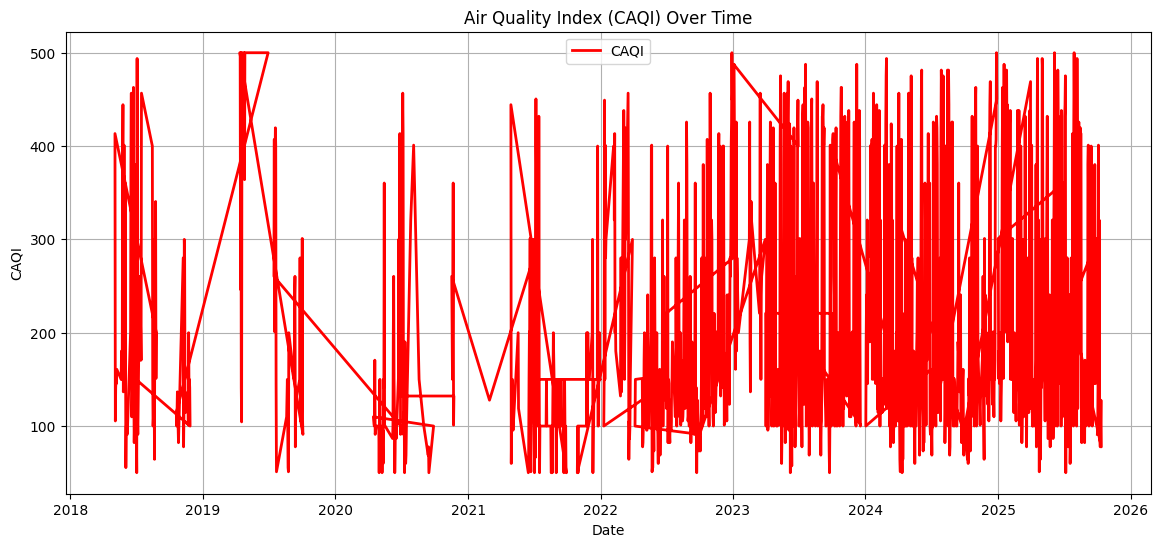

In [15]:
import matplotlib.pyplot as plt

# Time series plot of CAQI
plt.figure(figsize=(14,6))
plt.plot(df.index, df['CAQI'], color='red', linewidth=2, label='CAQI')
plt.xlabel('Date')
plt.ylabel('CAQI')
plt.title('Air Quality Index (CAQI) Over Time')
plt.legend()
plt.grid(True)
plt.show()


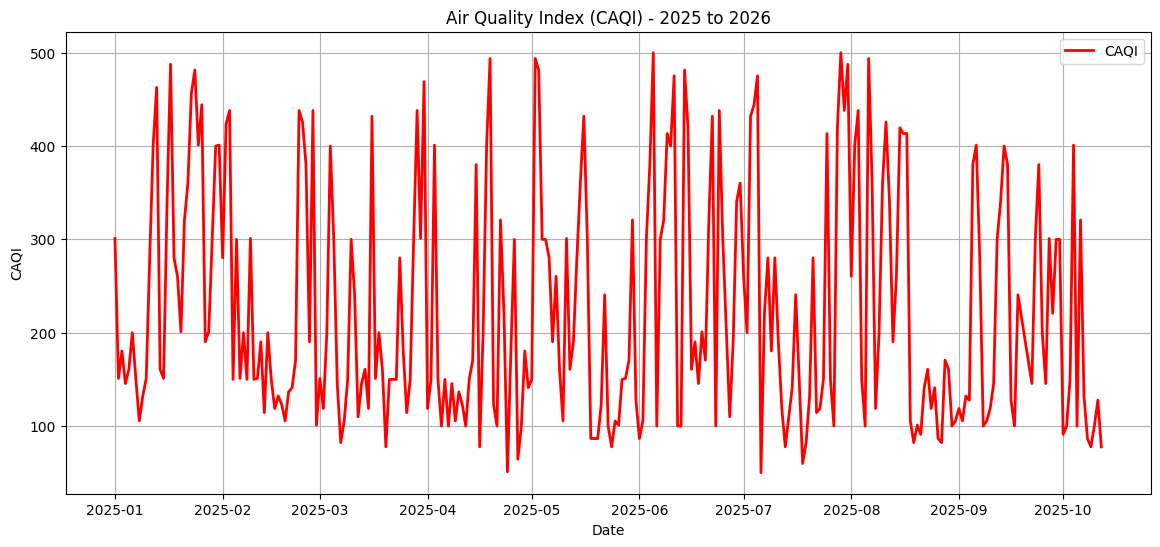

In [17]:
import matplotlib.pyplot as plt

# Ensure the index is datetime and sorted
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Filter data for 2025-2026
df_zoom = df.loc['2025-01-01':'2026-12-31']

# Plot CAQI over the zoomed period
plt.figure(figsize=(14,6))
plt.plot(df_zoom.index, df_zoom['CAQI'], color='red', linewidth=2, label='CAQI')
plt.xlabel('Date')
plt.ylabel('CAQI')
plt.title('Air Quality Index (CAQI) - 2025 to 2026')
plt.legend()
plt.grid(True)
plt.show()


For a better clarity of the plots we will softened the plots and take the average sub-index for 7 days and not 7 days by day

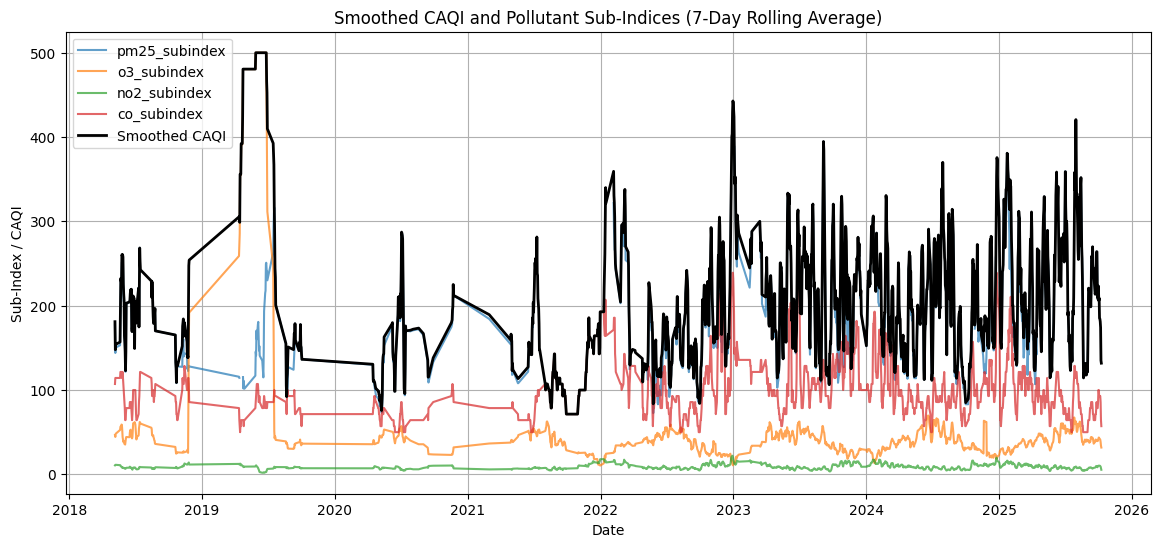

In [ ]:
# Apply 7-day rolling average to sub-indices and CAQI
subindex_cols = [p+'_subindex' for p in breakpoints.keys()]
df_smooth = df[subindex_cols + ['CAQI']].rolling(window=7, center=True).mean()

# Plot smoothed CAQI and sub-indices
plt.figure(figsize=(14,6))
for col in subindex_cols:
    plt.plot(df_smooth.index, df_smooth[col], label=col, alpha=0.7)
plt.plot(df_smooth.index, df_smooth['CAQI'], color='purple', linewidth=2, label='Smoothed CAQI')
plt.xlabel('Date')
plt.ylabel('Sub-Index / CAQI')
plt.title('Smoothed CAQI and Pollutant Sub-Indices (7-Day Rolling Average)')
plt.legend()
plt.grid(True)
plt.show()

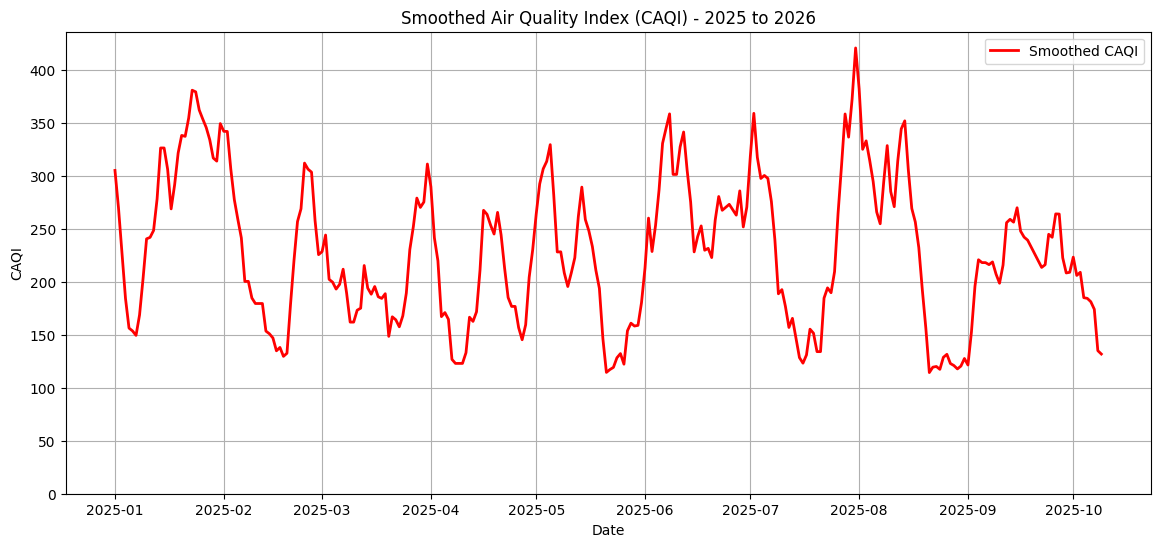

In [20]:
import matplotlib.pyplot as plt

# Ensure index is sorted
df = df.sort_index()

# Apply 7-day rolling average to CAQI
df['CAQI_smooth'] = df['CAQI'].rolling(window=7, center=True).mean()

# Filter data for 2025-2026
df_zoom = df.loc['2025-01-01':'2026-12-31']

# Plot smoothed CAQI for 2025-2026
plt.figure(figsize=(14,6))
plt.plot(df_zoom.index, df_zoom['CAQI_smooth'], color='red', linewidth=2, label='Smoothed CAQI')
plt.xlabel('Date')
plt.ylabel('CAQI')
plt.title('Smoothed Air Quality Index (CAQI) - 2025 to 2026')
plt.legend()
plt.grid(True)

# Force y-axis to start at 0
plt.ylim(bottom=0)

plt.show()


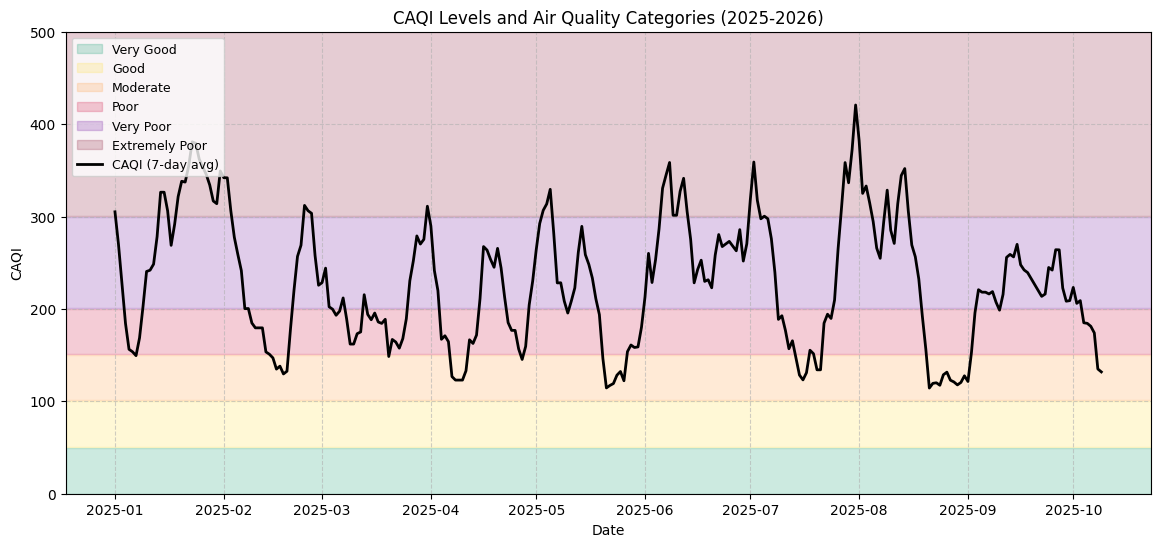

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure index is sorted and CAQI smoothed
df = df.sort_index()
df['CAQI_smooth'] = df['CAQI'].rolling(window=7, center=True).mean()
df_zoom = df.loc['2025-01-01':'2026-12-31']

# Define CAQI categories (EU Standard)
zones = [
    (0, 50, "Very Good", "#009966"),
    (51, 100, "Good", "#ffde33"),
    (101, 150, "Moderate", "#ff9933"),
    (151, 200, "Poor", "#cc0033"),
    (201, 300, "Very Poor", "#660099"),
    (301, 500, "Extremely Poor", "#7e0023"),
]

# Plot
plt.figure(figsize=(14,6))

# Background color bands
for lower, upper, label, color in zones:
    plt.axhspan(lower, upper, color=color, alpha=0.2, label=label)

# CAQI curve
plt.plot(df_zoom.index, df_zoom['CAQI_smooth'], color='black', linewidth=2, label='CAQI (7-day avg)')

# Labels and style
plt.xlabel('Date')
plt.ylabel('CAQI')
plt.title('CAQI Levels and Air Quality Categories (2025-2026)')
plt.ylim(bottom=0, top=500)
plt.grid(True, linestyle='--', alpha=0.6)

# Only one label per color band
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=9)

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Define CAQI categories
zones = [
    (0, 50, "Very Good", "#009966"),
    (51, 100, "Good", "#ffde33"),
    (101, 150, "Moderate", "#ff9933"),
    (151, 200, "Poor", "#cc0033"),
    (201, 300, "Very Poor", "#660099"),
    (301, 500, "Extremely Poor", "#7e0023"),
]

# Ensure sorted and smoothed
df = df.sort_index()
df['CAQI_smooth'] = df['CAQI'].rolling(window=7, center=True).mean()

# Use full dataset instead of filtering
df_zoom = df.copy()

# Categorize CAQI
def categorize_caqi(value):
    for low, high, label, color in zones:
        if low <= value <= high:
            return label
    return None

df_zoom['CAQI_Category'] = df_zoom['CAQI_smooth'].apply(categorize_caqi)

# Compute percentages
category_counts = df_zoom['CAQI_Category'].value_counts(dropna=True)
category_percent = 100 * category_counts / category_counts.sum()

# Summary DataFrame
summary = pd.DataFrame(zones, columns=['Min', 'Max', 'Category', 'Color'])
summary['Percentage'] = summary['Category'].map(category_percent).fillna(0).round(2)
summary = summary.sort_values(by='Min')

# Display styled table
def highlight_color(val):
    return f'background-color: {val}'

styled_summary = (
    summary.style
    .applymap(highlight_color, subset=['Color'])
    .format({'Percentage': '{:.2f}%'})
    .hide(axis='columns', subset=['Min','Max'])
)

styled_summary


C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_17412\1530572604.py:46: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_color, subset=['Color'])


,Category,Color,Percentage
0,Very Good,#009966,0.00%
1,Good,#ffde33,3.97%
2,Moderate,#ff9933,23.52%
3,Poor,#cc0033,26.55%
4,Very Poor,#660099,35.48%
5,Extremely Poor,#7e0023,10.48%


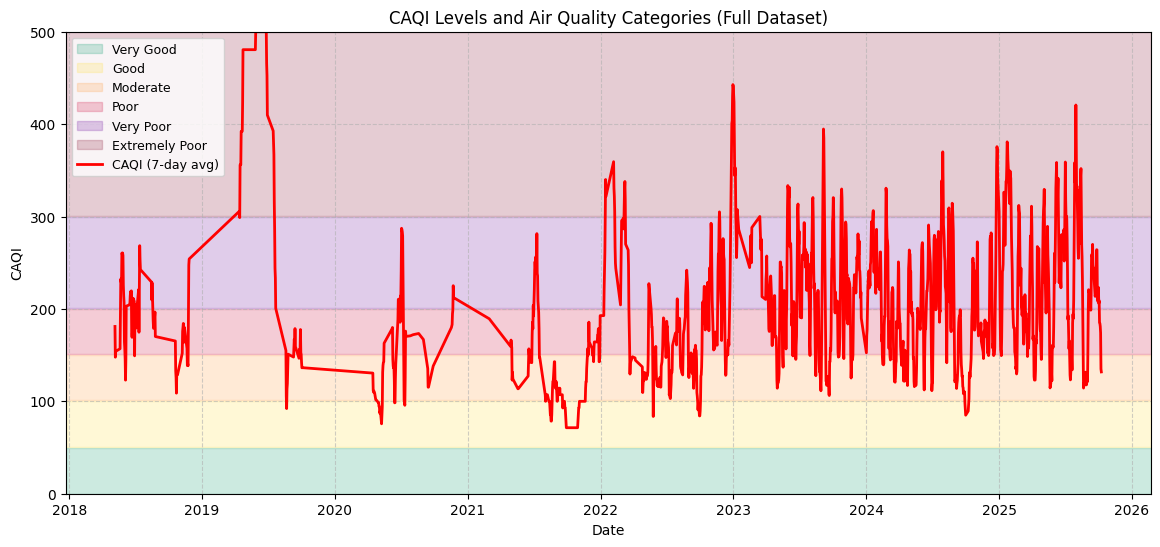

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure index is sorted and CAQI smoothed
df = df.sort_index()
df['CAQI_smooth'] = df['CAQI'].rolling(window=7, center=True).mean()

# Use entire dataset
df_zoom = df.copy()

# Define CAQI categories (EU Standard)
zones = [
    (0, 50, "Very Good", "#009966"),
    (51, 100, "Good", "#ffde33"),
    (101, 150, "Moderate", "#ff9933"),
    (151, 200, "Poor", "#cc0033"),
    (201, 300, "Very Poor", "#660099"),
    (301, 500, "Extremely Poor", "#7e0023"),
]

# Plot
plt.figure(figsize=(14,6))

# Background color bands
for lower, upper, label, color in zones:
    plt.axhspan(lower, upper, color=color, alpha=0.2, label=label)

# CAQI curve
plt.plot(df_zoom.index, df_zoom['CAQI_smooth'], color='red', linewidth=2, label='CAQI (7-day avg)')

# Labels and style
plt.xlabel('Date')
plt.ylabel('CAQI')
plt.title('CAQI Levels and Air Quality Categories (Full Dataset)')
plt.ylim(bottom=0, top=500)
plt.grid(True, linestyle='--', alpha=0.6)

# Only one label per color band
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=9)

plt.show()
